# Micrograd Experiments

Following this video: https://www.youtube.com/watch?v=VMj-3S1tku0

In [1]:
!which python

/Users/grzenda/.cache/uv/archive-v0/xEeg_NOqbaIXiNqd0w8E0/bin/python


In [2]:
!python --version

Python 3.13.5


In [3]:
#!uv add graphviz

In [4]:
import math

import matplotlib.pyplot as plt
import numpy as np
from graphviz import Digraph

%matplotlib inline

## Derivative (single input)

In [5]:
def f(x):
    return 3 * x**2 - 4 * x + 5

In [6]:
f(3.0)

20.0

In [7]:
xs = np.arange(-5, 5, 0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [8]:
ys = f(xs)

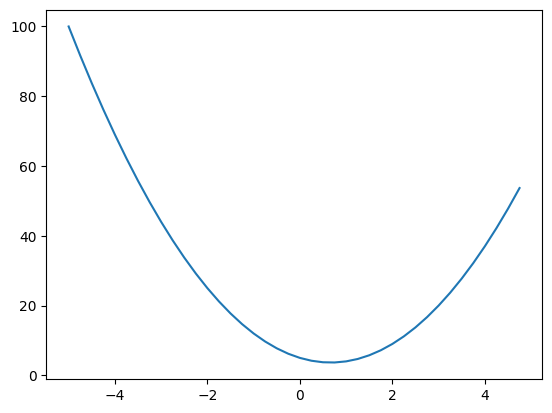

In [9]:
plt.plot(xs, ys)

We could write a function for the symbolic derivative but nobody writes out the more complicated functions of deep networks

This example would be: $$ 6x - 4 $$

Instead we use a numerical approximation

In [10]:
h = 0.000001
x = 3.0
(f(x + h) - f(x)) / h

14.000003002223593

## Derivative (multiple inputs)

In [11]:
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)

4.0


In [12]:
h = 0.000001
a = 2.0
b = -3.0
c = 10.0
d1 = a * b + c
a += h
d2 = a * b + c
print("d1", d1)
print("d2", d2)
print("slope", (d2 - d1) / h)

d1 4.0
d2 3.9999969999999996
slope -3.000000000419334


In [13]:
h = 0.000001
a = 2.0
b = -3.0
c = 10.0
d1 = a * b + c
b += h
d2 = a * b + c
print("d1", d1)
print("d2", d2)
print("slope", (d2 - d1) / h)

d1 4.0
d2 4.000002
slope 2.000000000279556


In [14]:
h = 0.000001
a = 2.0
b = -3.0
c = 10.0
d1 = a * b + c
c += h
d2 = a * b + c
print("d1", d1)
print("d2", d2)
print("slope", (d2 - d1) / h)

d1 4.0
d2 4.000000999999999
slope 0.9999999992515995


NB: Your sensitivity with respect to your neighbors depends on your relationships to the other inputs. 

## Data Structure for Derivatives 

In [58]:
class Value:
    def __init__(self, data, _children=(), _op="", _label=""):
        self.data = data
        self.grad = 0.0
        # keep track of the values this data came from
        self._prev = set(_children)
        # keep track of the operation that made it
        self._op = _op
        self._label = _label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")
        return out

    def __pow__(self, other):
        out = Value(self.data**other.data, (self, other), "**")
        return out

    # you can write a forward for any function
    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), "tanh")
        return out

In [16]:
a = Value(2.0, _label="a")
b = Value(-3.0, _label="b")
c = Value(10.0, _label="c")

In [17]:
a, b

(Value(data=2.0), Value(data=-3.0))

In [18]:
a + b

Value(data=-1.0)

In [19]:
a * b + c

Value(data=4.0)

In [20]:
d = a**a

In [21]:
d._prev

{Value(data=2.0)}

In [22]:
d._op

'**'

In [23]:
d._label = "d"

## Viz Expressions

In [24]:
def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label=f" {n._label} | data: {n.data:.4f} | grad: {n.grad:.4f}", shape="record")
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

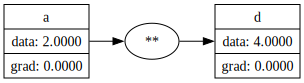

In [25]:
draw_dot(d)

## Complication Expressions

In [26]:
a = Value(2.0, _label="a")
b = Value(-3.0, _label="b")
c = Value(10.0, _label="c")

In [27]:
e = a * b
e._label = "e"
d = e + c
d._label = "d"
f = Value(-2.0, _label="f")
L = d * f
L._label = "L"

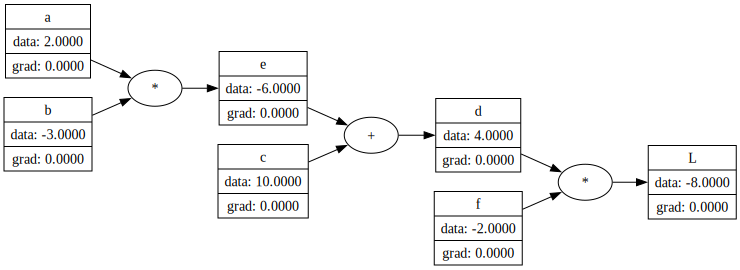

In [28]:
draw_dot(L)

This visualizes the forward pass. Now for the back propagation we are going to calculate the derivative L wuth respect to every node. In the end we are interested the derivative of the Loss with respect to the leaf nodes (inputs) which in deep learning would be weights.

Data is also an input in deep learning but because it is fixed we ignore it and only do back prop on the weights which we will iteratively update.

In [29]:
def numerical_est_derv():
    h = 0.0001

    a = Value(2.0, _label="a")
    b = Value(-3.0, _label="b")
    c = Value(10.0, _label="c")
    e = a * b
    e._label = "e"
    d = e + c
    d._label = "d"
    f = Value(-2.0, _label="f")
    L = d * f
    L._label = "L"
    L1 = L.data

    a = Value(2.0, _label="a")
    b = Value(-3.0, _label="b")
    c = Value(10.0, _label="c")
    e = a * b
    e._label = "e"
    d = e + c
    d._label = "d"
    d.data += h
    f = Value(-2.0, _label="f")
    L = d * f
    L._label = "L"
    L2 = L.data
    print((L2 - L1) / h)

## Back Propagation

In [30]:
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0

In [31]:
numerical_est_derv()

-1.9999999999953388


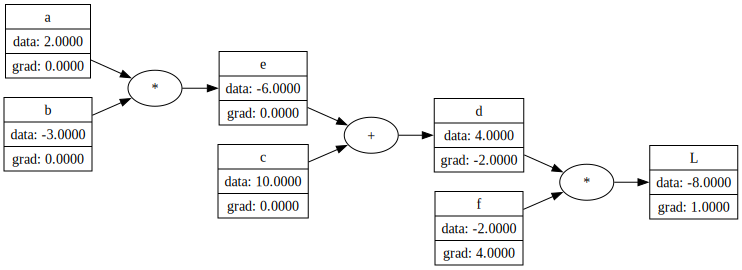

In [32]:
draw_dot(L)

If we know how c and e impact d, and how d impacts L, we can use the chain rule in calculus to put them together. 

$$ \frac{\delta L}{\delta c}  = \frac{\delta L}{\delta d}  * \frac{\delta d}{\delta c} $$

In [33]:
c.grad = -2.0
e.grad = -2.0

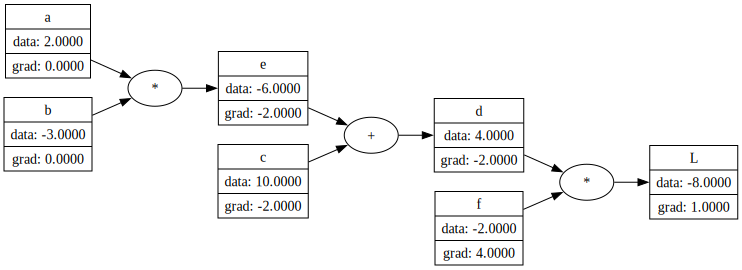

In [34]:
draw_dot(L)

In [35]:
a.grad = 6.0
b.grad = -4.0

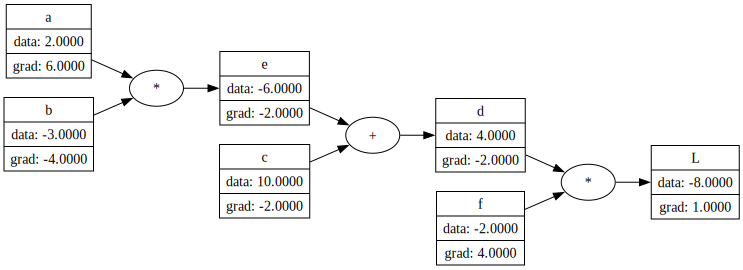

In [36]:
draw_dot(L)

A small positive change is how the gradient is calculated. So if there is a negative gradient and you move in its direction, you are doing the opposite of a small positive change, and therefore moving the final value in a positive direction.

## Neurons

### Activation - TANH

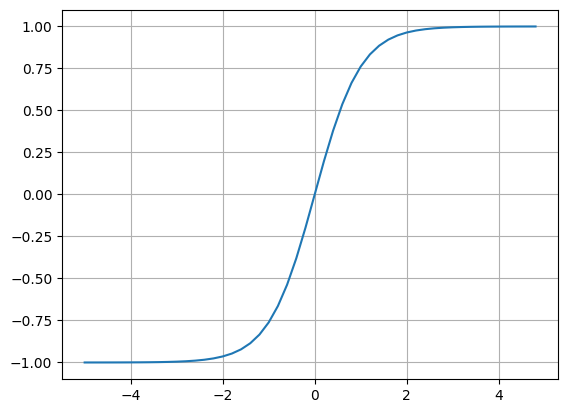

In [37]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)))
plt.grid();

### Two Weights

In [44]:
x1 = Value(2.0, _label="x1")
x2 = Value(0.0, _label="x2")
w1 = Value(-3.0, _label="w1")
w2 = Value(1.0, _label="w2")
b = Value(6.8813735870195432, _label="b")

In [45]:
x1w1 = x1 * w1
x1w1._label = "x1w1"
x2w2 = x2 * w2
x2w2._label = "x2w2"
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2._label = "x1w1 + x2w2"
n = x1w1x2w2 + b
n._label = "n"
o = n.tanh()
o._label = "o"

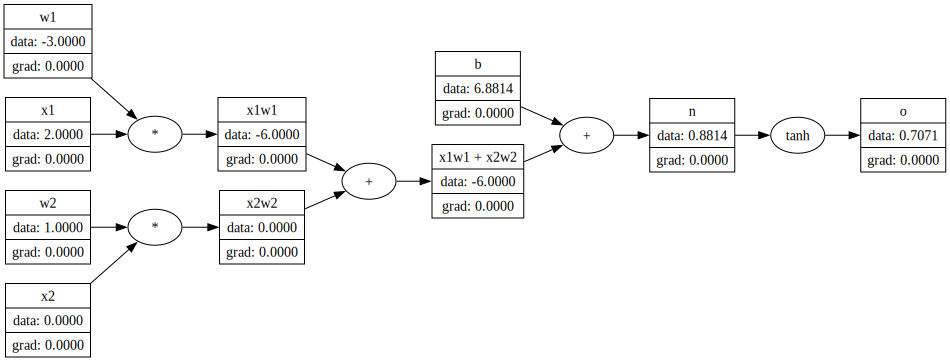

In [46]:
draw_dot(o)

We care about the derivative of w1 and w2 with respect to o the most. These are the weights that we are going to iteratively update so that we can better fit the model. These are our paramemeters. Remember this is just one neuron and in a regular neural network there would be many neurons connected (and a loss function at the end).

In [47]:
o.grad = 1.0

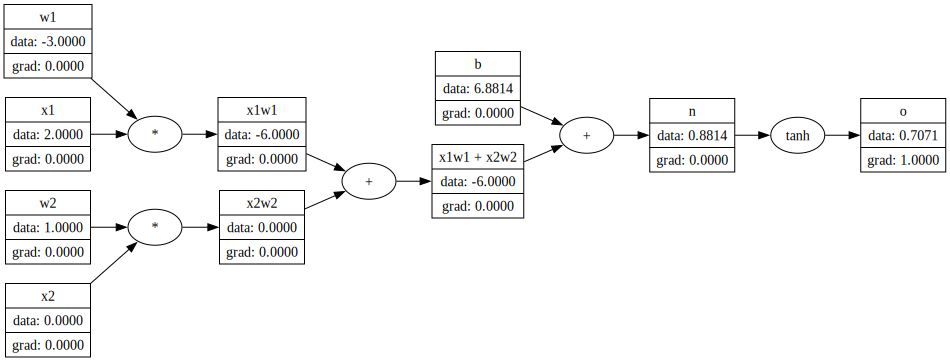

In [48]:
draw_dot(o)

For each function in the forward pass we need to understand how to take the derivative so we can do the backward pass.

In [49]:
n.grad = 1 - o.data**2

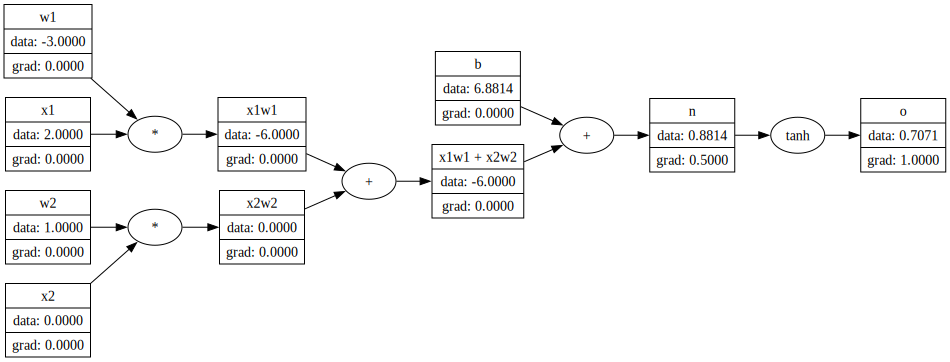

In [50]:
draw_dot(o)

The local derivative of a sum operation is 1.0, so the plus nodes just sends the 0.5 derivative of the n node to both the nodes in this operation.

In [51]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [52]:
x1w1.grad = 0.5
x2w2.grad = 0.5

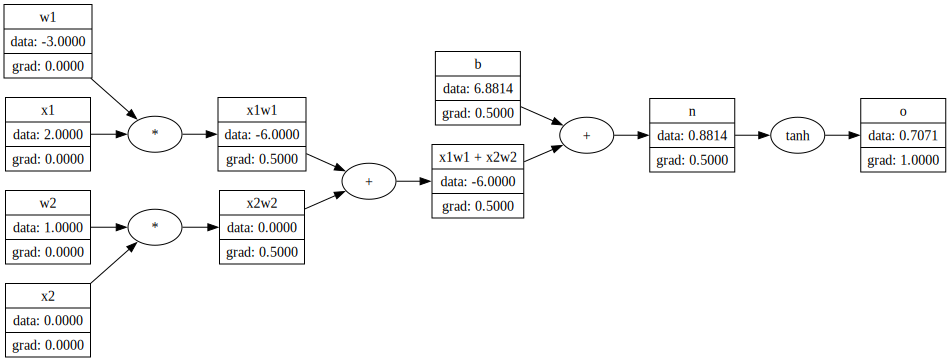

In [53]:
draw_dot(o)

In [54]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

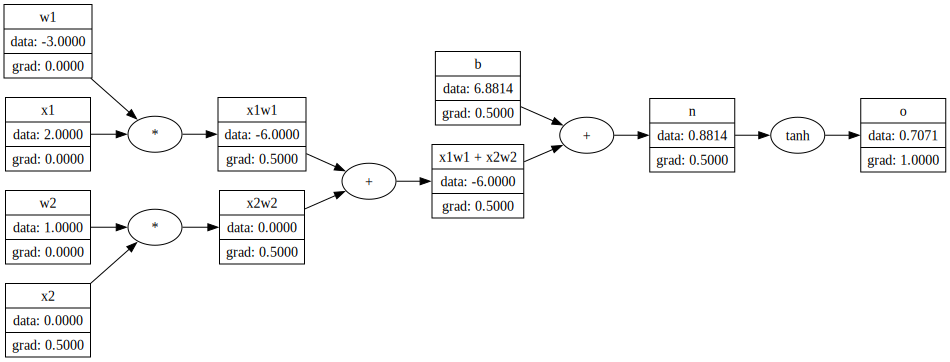

In [55]:
draw_dot(o)

In [56]:
w1.grad = x1.data * x1w1.grad
x1.grad = w1.data * x1w1.grad

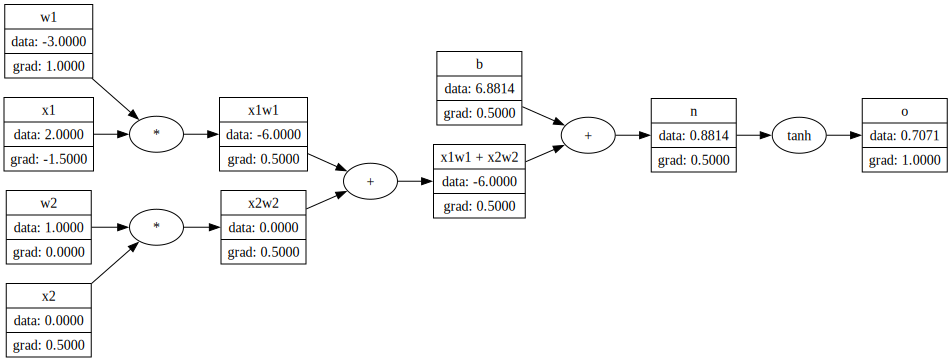

In [57]:
draw_dot(o)

## Backward Pass

In [87]:
class Value:
    def __init__(self, data, _children=(), _op="", _label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        # keep track of the values this data came from
        self._prev = set(_children)
        # keep track of the operation that made it
        self._op = _op
        self._label = _label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad

        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad

        out._backward = _backward
        return out

    def __pow__(self, other):
        out = Value(self.data**other.data, (self, other), "**")
        return out

    # you can write a forward for any function
    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), "tanh")

        def _backward():
            self.grad = (1 - t**2) * out.grad

        out._backward = _backward
        return out

In [80]:
x1 = Value(2.0, _label="x1")
x2 = Value(0.0, _label="x2")
w1 = Value(-3.0, _label="w1")
w2 = Value(1.0, _label="w2")
b = Value(6.8813735870195432, _label="b")

In [81]:
x1w1 = x1 * w1
x1w1._label = "x1w1"
x2w2 = x2 * w2
x2w2._label = "x2w2"
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2._label = "x1w1 + x2w2"
n = x1w1x2w2 + b
n._label = "n"
o = n.tanh()
o._label = "o"

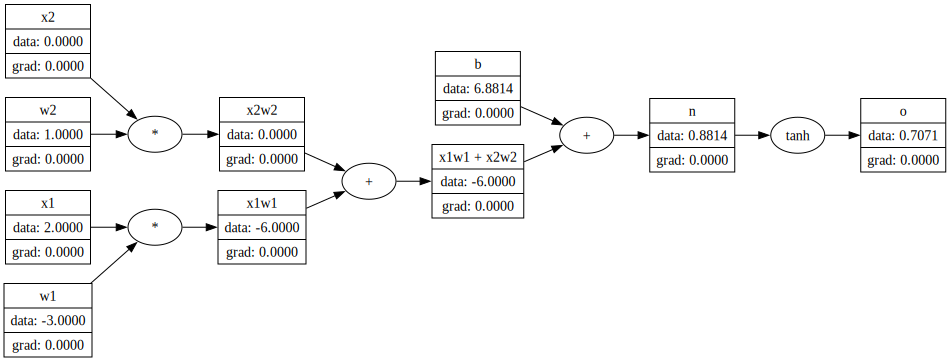

In [82]:
draw_dot(o)

In [85]:
# need to init the final result with a gradient of 1 so it doesn't zero out values when multiplied in the chain rule
o.grad = 1.0
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

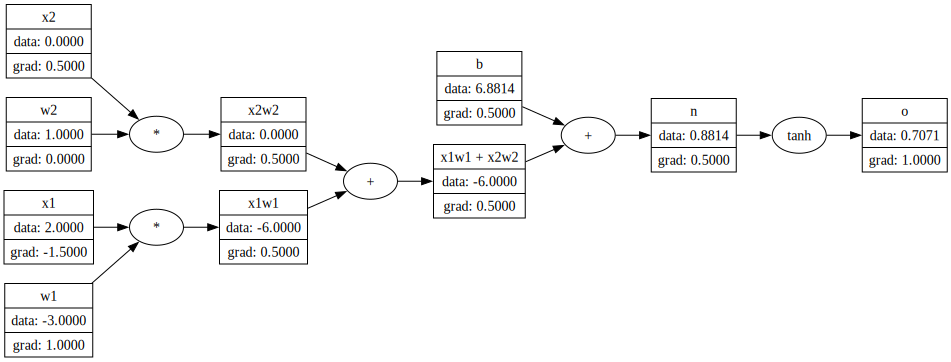

In [88]:
draw_dot(o)

## Automatic Backward

As we saw above we have to call backward in a very specific order. We can't call backprop until everything has been calculated past the node in the forward pass. We can use **topological sort** to get the order of the nodes.